In [88]:
# !pip install ucimlrepo
# !pip install cvxpy
# !pip install clarabel


In [89]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import cvxpy as cp
from matplotlib import pyplot as plt

In [90]:
# !! DO NOT MODIFY THIS CELL !!

# Download and preprocess the dataset.
# fetch dataset
heart_disease = fetch_ucirepo(id=45)
X = heart_disease.data.features
# Convert categorical features into one-hot encode
categorical_features = ['cp','thal','slope','restecg']
X = pd.get_dummies(X, columns=categorical_features)

y = heart_disease.data.targets
print(f"Number of samples in all full dataset is: {len(X)}.")

# Check if our train set has missing value
na_in_features = X.isna().any(axis=1).sum()
na_in_trainY = y.isna().sum()
print(f"Number of rows with missing values in features: {na_in_features}")

# Drop the rows with missing values.
indices_with_nan = X.index[X.isna().any(axis=1)]
X = X.drop(indices_with_nan)
y = y.drop(indices_with_nan)

# Divide train/test
np.random.seed(6464)
msk = np.random.rand(len(X)) < 0.75
X_train = X[msk]
X_test = X[~msk]
y_train = y[msk]
y_test = y[~msk]

# Convert problem to binary problem
X_train = np.array(X_train,dtype='float')
X_test = np.array(X_test,dtype='float')
y_train = np.array([-1 if i==0 else 1 for i in y_train.values],dtype='float')
y_test = np.array([-1 if i==0 else 1 for i in y_test.values],dtype='float')

print(f"Shapes: X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}")

Number of samples in all full dataset is: 303.
Number of rows with missing values in features: 4
Shapes: X_train: (216, 22), y_train: (216,), X_test: (83, 22), y_test: (83,)


In [91]:
# Normalize X_train and X_test using the statistics of X_train.
# 1. Compute the mean and standard deviation for each feature in X_train
# 2. Subtract the mean from each feature and divide by the standard deviation
#    for both X_train and X_test.

#YOUR CODE HERE!
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train_normalized = (X_train - mean) / std
X_test_normalized = (X_test - mean) / std

s1 = X_train_normalized.shape == X_train.shape
s2 = X_test_normalized.shape == X_test.shape

print("X_train shape assertion:", s1)
print("X_test shape assertion:", s2)


X_train shape assertion: True
X_test shape assertion: True


In [92]:
# Print the mean and standard deviation of the first and last feature.

# YOUR CODE HERE!
print(f"Mean of first feature: {mean[0]}")
print(f"Standard deviation of first feature: {std[0]}")
print(f"Mean of last feature: {mean[-1]}")
print(f"Standard deviation of  last feature: {std[-1]}")

Mean of first feature: 54.99074074074074
Standard deviation of first feature: 9.077847854724455
Mean of last feature: 0.5046296296296297
Standard deviation of  last feature: 0.49997856607007907


In [93]:
# Train SVM

# Complete the `trainSVM` function to find the optimal w and b that minimize
# the primal SVM objective given in the write-up.
# The function takes three inputs:
# - trainX: the normalized train features with shape (#train_samples, #features)
# - trainY: train labels with shape (#train_samples,)
# - C: C parameter of the minimization problem
# The function should return a three-tuple with:
# - w: the weight vector with shape (#features,)
# - b: the bias. A scalar with shape (1,)
# - xi: the slack variables with shape (#train_samples,)

# You can use cvxpy that we imported as cp
# You may find cp.Variable, cp.Minimize, cp.Problem useful
# For the problem solver, prefer the default, cp.CLARABEL

def trainSVM(trainX, trainY, C):

    # YOUR CODE HERE!
    n, m = trainX.shape
    w = cp.Variable(m)
    b = cp.Variable()
    xi = cp.Variable(n)

    # loss = cp.sum(cp.pos(1 - cp.multiply(trainY, trainX @ w + b)) + C * xi)
    # objective = cp.Minimize(loss)
    objective = cp.Minimize(0.5 * cp.norm(w, 2)**2 + C * cp.sum(xi))
    # constraints = [xi >= 0]
    constraints = [cp.multiply(trainY, trainX @ w + b) >= 1 - xi, xi >= 0]
    prob = cp.Problem(objective, constraints)
    prob.solve(solver = cp.CLARABEL)

    return w.value, b.value, xi.value

    

In [94]:
# Solve SVM with C = 1 and print the first three weights, b and the first
# three slack variables as instructed in the write-up

# YOUR CODE HERE!
w, b, xi = trainSVM(X_train_normalized, y_train, 1)
print(f"First three weights: {w[:3]}")
print(f"b: {b}")
print(f"First three slack variables: {xi[:3]}")

First three weights: [-0.01280084  0.51706872  0.27813637]
b: 0.08109278708401382
First three slack variables: [-1.70119328e-10 -1.64395885e-10 -1.69587409e-10]


In [95]:
# Solve SVM with C = 0 and print the first three weights, b and the first
# three slack variables as instructed in the write-up

# YOUR CODE HERE!
w, b, xi = trainSVM(X_train_normalized, y_train, 0)
print(f"First three weights: {w[:3]}")
print(f"b: {b}")
print(f"First three slack variables: {xi[:3]}")

First three weights: [ 3.09523259e-06 -8.18802636e-06 -9.46615246e-06]
b: -10.447621082517728
First three slack variables: [429.58840105 434.02071004 414.34670026]


#### Do you see any difference between the slack variables you found with C = 0 and C = 1?

Yes, there is a significant difference. When $C = 1$, the slack variables are nearly zero, meaning most points are correctly classified with minimal margin violations, while for $C = 0$, the slack variables are large, indicating that the model is allowing many misclassifications.  

This explains why we introduce the $C \sum \xi_i$ term in Soft-SVM, it penalizes misclassification, ensuring a balance between maximizing the margin and minimizing classification errors.



In [96]:
# Eval SVM

# Write a function to evaluate the SVM model given its `w` and `b` parameters
# on evaluation data `X_eval` and true labels `y_eval`.
#  1. Estimate the labels of `X_eval`.
#  2. Return the ratio of accurately estimated labels by comparing with `y_eval`.


def evalSVM(X_eval, y_eval, w, b):

    # YOUR CODE HERE!
    y_pred = np.sign(X_eval @ w + b)
    accuracy = np.mean(y_pred == y_eval)
    return accuracy


In [97]:
train_accuracies = []
test_accuracies = []
c_values = [a * 10 ** q for a in [1,3,6] for q in range(-4, 2)]
# c_values
# For each C value given in the homework, find optimal w, b
# values using the normalized train set. calculate the accuracy
# on train and test sets using found w and b.
# Save those values as we will plot them

# YOUR CODE HERE!
for c in c_values:
    w, b, _ = trainSVM(X_train_normalized, y_train, c)
    train_accuracies.append(evalSVM(X_train_normalized, y_train, w, b))
    w, b, _ = trainSVM(X_test_normalized, y_test, c)
    test_accuracies.append(evalSVM(X_test_normalized, y_test, w, b))

check_val_train = zip(c_values, train_accuracies)
for val in check_val_train:
    if val[1] == max(train_accuracies):
        print(f"Best C value for train set: {val[0]}, accuracy: {val[1]}")
        break

check_val_test = zip(c_values, test_accuracies)
for val in check_val_test:
    if val[1] == max(test_accuracies):
        print(f"Best C value for test set: {val[0]}, accuracy: {val[1]}")
        break

Best C value for train set: 10, accuracy: 0.8888888888888888
Best C value for test set: 10, accuracy: 0.963855421686747


In [98]:
test_accuracies
train_accuracies

[0.5092592592592593,
 0.8564814814814815,
 0.8611111111111112,
 0.8703703703703703,
 0.8657407407407407,
 0.8888888888888888,
 0.5092592592592593,
 0.8657407407407407,
 0.8796296296296297,
 0.8657407407407407,
 0.8842592592592593,
 0.8888888888888888,
 0.6990740740740741,
 0.8611111111111112,
 0.8703703703703703,
 0.875,
 0.8842592592592593,
 0.8796296296296297]

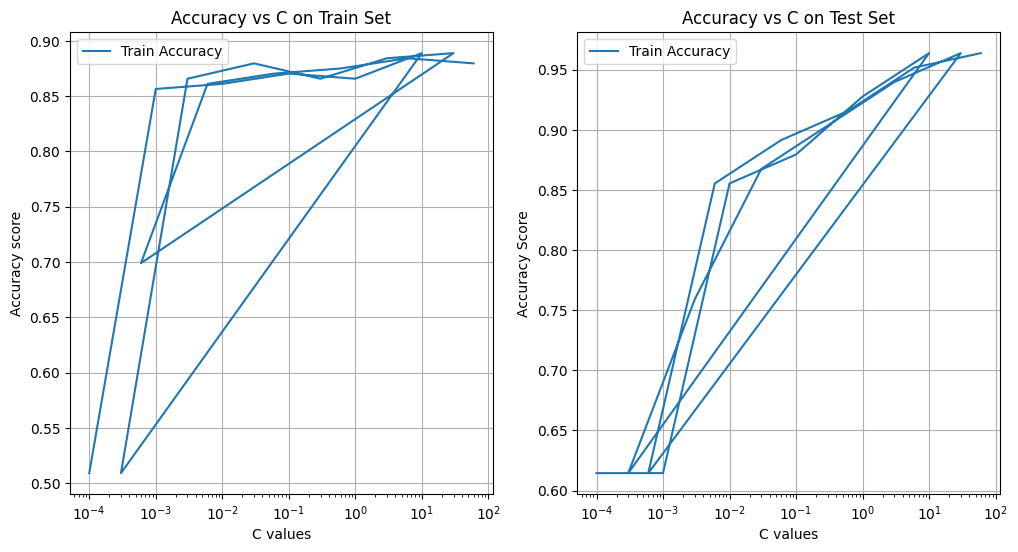

In [100]:
# Plotting and reporting the desired values

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(c_values, train_accuracies, label='Train Accuracy')
ax[0].set_xscale('log')
ax[0].set_xlabel('C values')
ax[0].set_ylabel('Accuracy score')
ax[0].legend()
ax[0].grid()
ax[0].set_title('Accuracy vs C on Train Set')

ax[1].plot(c_values, test_accuracies, label='Train Accuracy')
ax[1].set_xscale('log')
ax[1].set_xlabel('C values')
ax[1].set_ylabel('Accuracy Score')
ax[1].legend()
ax[1].grid()
ax[1].set_title('Accuracy vs C on Test Set')

plt.show()
